In [1]:
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn.externals import joblib

In [2]:
def get_time(x, c1, c2):     #find the difference between two date columns of dataframe x
    diff =  x[c2] - x[c1]
    days = diff.days
    days_to_hours = days * 24
    diff_btw_two_times = (diff.seconds) / 3600
    overall_hours = days_to_hours + diff_btw_two_times
    return overall_hours

In [3]:
file = 'delivery_new_nov_2018.xlsx'
data = pd.ExcelFile(file)
df = data.parse('Order History_1')

In [4]:
col_names= ['Created Time', 'Biker Assigned Time', 'Delivered Time','Orders in Progress for Biker', 'Total Orders to Assign', 'Qty']
df.dropna(subset=col_names, how='any', inplace = True)
col_names= ['Created Time', 'Biker Assigned Time', 'Biker Accepted Time', 'In Bike TIme', 'Delivered Time']

In [5]:
timestamp_info = pd.DataFrame(columns=['Created Time', 'Biker Assigned Time'])
timestamp_info[col_names] = df[col_names].apply(pd.to_datetime, format='%Y-%m-%d %H:%M:%S.%f')
info_taken = pd.DataFrame()
#info_taken['Hours2assign']= df.apply(get_time,c1='Created Time', c2='Biker Assigned Time', axis=1)
df['Hours2deliver']= df.apply(get_time, c1='Biker Assigned Time', c2='Delivered Time', axis=1)
#df['BikerID'], levels = pd.factorize(df['Biker'])
df['PendingOrderByBiker'] = df['Orders in Progress for Biker']
df['PendingOrdersLocationWise']= df['Total Orders to Assign']
#df['LocationCode'], levels = pd.factorize(df['Location Code'])
#df['BikerCode'], levels = pd.factorize(df['Biker Code'])
df['Location Code']
df['Biker Code']
df['CustomerCode'], levels = pd.factorize(df['Customer Code'])

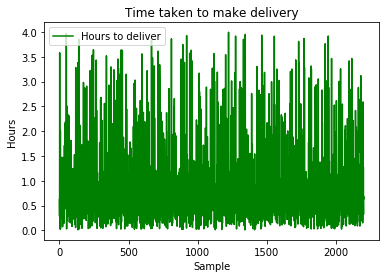

In [25]:
rm_grtr_4 =  df['Hours2deliver'] > 4
info_taken = df[~rm_grtr_4]
plt.plot(info_taken['Hours2deliver'].values, color= 'green', label= 'Hours to deliver') # p
plt.ylabel('Hours')
plt.xlabel('Sample')
plt.title('Time taken to make delivery')
plt.legend()

In [49]:
#df = df [~rm_grtr_4]
#df = df[~rm_neg]
timestamp_info = df[['Created Time', 'Biker Assigned Time']].values.astype(int)
location_code = df[['BikerCode', 'LocationCode','PendingOrdersLocationWise']].values
X = np.concatenate((timestamp_info, location_code), axis=1)
#X= info_taken[['BikerID', 'Hours2assign']].values #, 
Y= np.reshape(df['Hours2deliver'].values, -1)

In [50]:
X_trn, X_tst, Y_trn, Y_tst = train_test_split(X, Y, test_size=0.1)

In [51]:
tree_regression_model = tree.DecisionTreeRegressor(max_depth=15, min_samples_split=19, random_state=0)
trained_model = tree_regression_model.fit(X, Y)
joblib.dump(trained_model, 'model2_dt.sav')

['model2_dt.sav']

In [52]:
from sklearn.metrics import make_scorer
from sklearn.grid_search import GridSearchCV
tree_regression_Model = tree.DecisionTreeRegressor(random_state=0)
scoring = make_scorer(r2_score)
parameters={'max_depth': np.arange(2, 20), 'min_samples_split':np.arange(5, 20)}
#cross_validation = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(tree_regression_Model, parameters, cv=20, n_jobs=6, scoring=scoring, verbose=1)

In [53]:
grid_search.fit(X_trn,Y_trn)

Fitting 20 folds for each of 270 candidates, totalling 5400 fits


[Parallel(n_jobs=6)]: Done 908 tasks      | elapsed:    1.2s
[Parallel(n_jobs=6)]: Done 5400 out of 5400 | elapsed:    7.9s finished


GridSearchCV(cv=20, error_score='raise',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=0, splitter='best'),
       fit_params={}, iid=True, n_jobs=6,
       param_grid={'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19]), 'min_samples_split': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])},
       pre_dispatch='2*n_jobs', refit=True, scoring=make_scorer(r2_score),
       verbose=1)

In [54]:
print(grid_search.best_params_)
print(grid_search.best_estimator_.feature_importances_)

{'max_depth': 18, 'min_samples_split': 13}
[0.18383193 0.31737637 0.11216936 0.29078077 0.09584157]


In [61]:
predict_model = trained_model.predict(X_tst)
#predict_model = grid_search.best_estimator_.predict(X_tst)

In [62]:
print("Mean squared error: "  )
mse= mean_squared_error(Y_tst, predict_model)
print(mse)

r2 = r2_score(Y_tst, predict_model, sample_weight=None, multioutput='uniform_average')
print(r2)
adj_r2 = 1-(1-r2) * (X_tst.shape[0] -1)/(X_tst.shape[0]-X_tst.shape[1] -1)
adj_r2

Mean squared error: 
0.4628523350383608
0.7926781155601572


0.7880709625726052

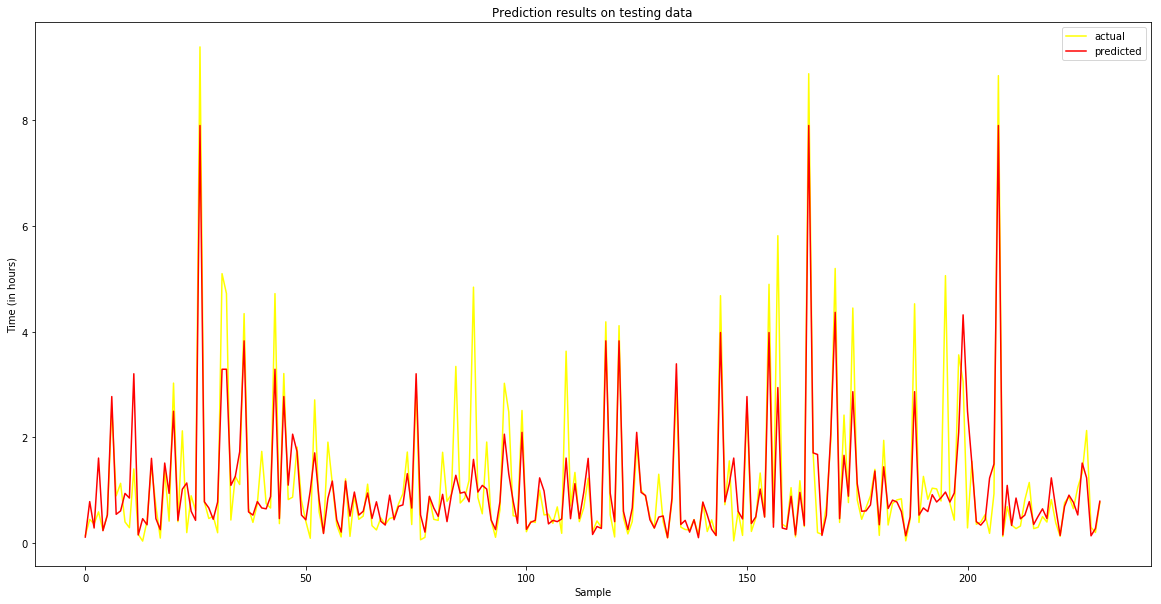

In [64]:
plt.figure(figsize=(20,10))
plt.plot(Y_tst, color= 'yellow', label= 'actual') # p
plt.plot(predict_model, color= 'red', label= 'predicted') # p
plt.xlabel('Sample')
plt.ylabel('Time (in hours)')
plt.title('Prediction results on testing data')
plt.legend()
plt.show()

<H2> Convert time in to 2 dimension (sine and cosine) because of cyclic nature of time <H2>

In [81]:
created_week, created_day, df['BikerAssignedTime'] = zip(*[(d.dayofweek, d.date().day, 
                                                 d.date()) for d in df['Biker Assigned Time']])

In [5]:
deliver_week, deliver_day, df['deliver_time'] = zip(*[(d.dayofweek, d.date().day, d.date()) 
                                                                    for d in df['Delivered Time']])

In [82]:
df['diff'] = df['Biker Assigned Time'] - df['BikerAssignedTime'].apply(pd.to_datetime)

In [83]:
df['seconds'] = df['diff'].dt.total_seconds()

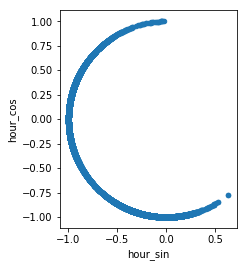

In [84]:
df['hour_sin'] = np.sin(2 * np.pi * df['seconds']/86400.0)
df['hour_cos'] = np.cos(2 * np.pi * df['seconds']/86400.0)
df.plot.scatter('hour_sin','hour_cos').set_aspect('equal')

In [9]:
df['del_diff'] = df['Delivered Time'] - df['deliver_time'].apply(pd.to_datetime)
df['del_seconds'] = df['del_diff'].dt.total_seconds() 

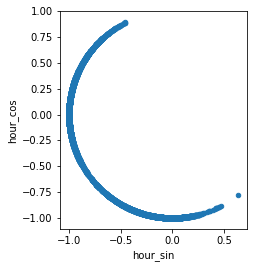

In [10]:
df['del_sin'] = np.sin(2 * np.pi * df['del_seconds']/86400.0)
df['del_cos'] = np.cos(2 * np.pi * df['del_seconds']/86400.0)
df.plot.scatter('hour_sin','hour_cos').set_aspect('equal')

In [90]:
X = df[['hour_sin', 'hour_cos', 'BikerCode', 'LocationCode', 'CustomerCode', 'Orders in Progress for Biker', 'Total Orders to Assign', 'Qty']].values
#Y = df[['del_sin', 'del_cos']].values
Y = df['Hours2deliver'].values
X_trn, X_tst, Y_trn, Y_tst = train_test_split(X, Y, test_size=0.3, random_state=42)

In [87]:
tree_regression_model = tree.DecisionTreeRegressor(max_depth=6, min_samples_split=19)
trained_model = tree_regression_model.fit(X_trn, Y_trn)

In [88]:
predict_model = trained_model.predict(X_tst)

In [95]:
print("Mean squared error: "  )
mse= mean_squared_error(Y_tst, predict_model,)
print(mse)

print('r2')
r2 = r2_score(Y_tst, predict_model, sample_weight=None, multioutput='uniform_average')
print(r2)
adj_r2 = 1-(1-r2) * (X_tst.shape[0] -1)/(X_tst.shape[0]-X_tst.shape[1] -1)
adj_r2

Mean squared error: 
1.0519457736707793
r2
0.36951815650701203


0.36831120394708294

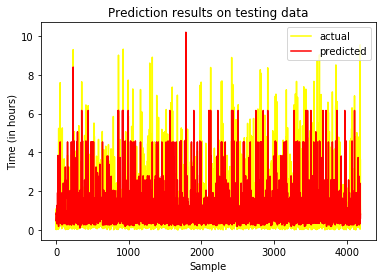

In [96]:
plt.plot(Y_tst, color= 'yellow', label= 'actual') # p
plt.plot(predict_model, color= 'red', label= 'predicted') # p
plt.xlabel('Sample')
plt.ylabel('Time (in hours)')
plt.title('Prediction results on testing data')
plt.legend()
plt.show()

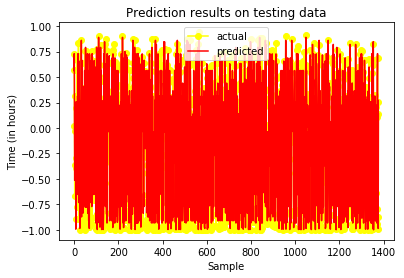

In [16]:
plt.plot(Y_tst[:,1], color= 'yellow',marker='o', label= 'actual') # p
plt.plot(predict_model[:,1], color= 'red', label= 'predicted') # p
plt.xlabel('Sample')
plt.ylabel('Time (in hours)')
plt.title('Prediction results on testing data')
plt.legend()
plt.show()

In [18]:
total_seconds = 60*60*24
sine_sec = np.abs((np.arcsin(predict_model[:,0]))*(total_seconds/2*np.pi))
sine_autal_sec = np.abs((np.arcsin(Y_tst[:,0]))*(total_seconds/2*np.pi))
cosine_sec = np.abs((np.arcsin(predict_model[:,1]))*(total_seconds/2*np.pi))
cosine_autal_sec = np.abs((np.arcsin(Y_tst[:,1]))*(total_seconds/2*np.pi))

In [20]:
df1 = pd.DataFrame()
df1['sine_sec'] = sine_sec
df1['sine_autal_sec'] = sine_autal_sec
df1['cosine_sec'] = cosine_sec
df1['cosine_autal_sec'] = cosine_autal_sec

In [21]:
df1.to_csv('model2_time_comparison.csv', sep=',', index=False)